# Pytorch with GPU

### Imports

In [35]:
from typing import Tuple, List
from collections import deque

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim import Optimizer

import numpy as np
from torch import Tensor

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.loss import _Loss

from lincoln.pytorch.layers import PyTorchLayer, DenseLayer
from lincoln.pytorch.model import PyTorchModel
from lincoln.pytorch.train import PyTorchTrainer
from lincoln.pytorch.preprocessor import ConvNetPreprocessor
from lincoln.pytorch.utils import assert_dim, permute_data
print("all libs imported")

all libs imported


### Set Constants 

In [36]:
SEED = 20190325
# NUM_THREADS = 16 # for interop parallelism 
NUM_WORKERS = 16 # for torch.DataLoader 
USE_GPU = True
# DEFAULT_DTYPE = torch.cuda.HalfTensor
DEFAULT_DTYPE = torch.FloatTensor
print("SEED:", SEED)
# print("NUM_THREADS:", NUM_THREADS)
print("NUM_WORKERS:", NUM_WORKERS)
print("USE_GPU:", USE_GPU)
print("DEFAULT_DTYPE", DEFAULT_DTYPE)

SEED: 20190325
NUM_WORKERS: 16
USE_GPU: True
DEFAULT_DTYPE <class 'torch.FloatTensor'>


### Prime Torch with Seed

In [37]:
torch.manual_seed(SEED);
print("seed: ", SEED)

seed:  20190325


### Enable GPU

In [38]:
# setup gpu
if USE_GPU:
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
    else:
        print("gpu not available")
        import sys
        sys.exit()
else:
    device = torch.device("cpu")
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda:0


### Set default Tensor type (cpu or cuda)
Not sure if we really want to do this. It seems non-canonical. 
No, we don't want to do this because it doesn't play well with multiprocessing.
https://discuss.pytorch.org/t/is-there-anything-wrong-with-setting-default-tensor-type-to-cuda/27949/3

In [39]:
# if USE_GPU:
#     # set default Tensor type (cpu or cuda)
#     torch.set_default_tensor_type('torch.cuda.FloatTensor')
if DEFAULT_DTYPE:
    torch.set_default_tensor_type(DEFAULT_DTYPE)
print("default Tensor type:", torch.tensor([3., 3.]).dtype)

default Tensor type: torch.float32


### Set num threads

In [40]:
# set num_threads
# torch.set_num_threads(NUM_THREADS)
print("num threads set: ", torch.get_num_threads())

num threads set:  16


### Enable autoreloading of modules

In [41]:
# autoreload reloads modules automatically before entering the 
# execution of code typed at the IPython prompt.
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2
print("modules autorelading enabled")
# !jupyter nbextension list

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
modules autorelading enabled


### Load Boston dataset 

In [42]:
from sklearn.datasets import load_boston

boston = load_boston()
data = boston.data
target = boston.target
features = boston.feature_names

from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)
X_train, X_test, y_train, y_test = Tensor(X_train), Tensor(X_test), Tensor(y_train), Tensor(y_test)

print("X_train length:", len(X_train))
print("y_train length:", len(y_train))
print("X_test length:", len(X_test))
print("y_test length:", len(y_test))

print("data loaded to cpu")

if USE_GPU:
    print("moving data to GPU")
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)

# X_train, X_test, y_train, y_test = Tensor(X_train).to(device), Tensor(X_test).to(device), Tensor(y_train).to(device), Tensor(y_test).to(device)

X_train length: 354
y_train length: 354
X_test length: 152
y_test length: 152
data loaded to cpu
moving data to GPU


### Define Boston model

In [43]:
class BostonModel(PyTorchModel):

    def __init__(self,
                 hidden_size: int = 13,
                 hidden_dropout: float = 1.0):
        super().__init__()
        self.dense1 = DenseLayer(13, hidden_size,
                                 activation=nn.Tanh(),
                                 dropout = hidden_dropout)
        self.dense2 = DenseLayer(hidden_size, 1)

    def forward(self, x: Tensor,
                inference: bool = False) -> Tensor:

        assert_dim(x, 2)

        assert x.shape[1] == 13

        x = self.dense1(x, inference)
        return self.dense2(x, inference),
print("model defined")

model defined


### Instantiate Model

In [44]:
# model, optimizer, loss
pytorch_boston_model = BostonModel(hidden_size=13, hidden_dropout=0.8)
if USE_GPU:
    pytorch_boston_model.to(device)
optimizer = optim.SGD(pytorch_boston_model.parameters(), lr=0.001, momentum=0.9)
print("model object instantiated")

model object instantiated


### Instantiate Loss 

In [45]:
criterion = nn.MSELoss() # this is from pytorch
                         # https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html

### Instantiate a Trainer

In [46]:
trainer = PyTorchTrainer(pytorch_boston_model, optimizer, criterion, device)
print("trainer instantiated")

trainer instantiated


### Fit the model

In [47]:
import time
start = time.time()
trainer.fit(X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            epochs=100,
            eval_every=10,
            final_lr_exp = 0.001)
print("done in ", time.time()-start, " seconds")

The loss after 1 epochs was 440.18560791015625


/mnt/md1/home/ascott/ascott_svn/SFSU/Fall_2019/CSC898/venv_python3.6_pythia/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


The loss after 11 epochs was 22.50460433959961
The loss after 21 epochs was 18.614288330078125
The loss after 31 epochs was 16.40505599975586
The loss after 41 epochs was 19.229036331176758
The loss after 51 epochs was 16.77082633972168
The loss after 61 epochs was 16.97479820251465
The loss after 71 epochs was 15.664215087890625
The loss after 81 epochs was 15.930442810058594
The loss after 91 epochs was 16.088298797607422
done in  1.9992201328277588  seconds


* cpu: 1.492981195449829  seconds
* gpu: 1.9997313022613525  seconds


In [48]:
torch.mean(torch.pow(pytorch_boston_model(X_test, inference=True)[0] - y_test, 2)).item()

15.929999351501465

### Make predictions, reshape to 1x 

In [49]:
test_pred = pytorch_boston_model(X_test)[0].view(-1)
test_actual = y_test


### Move back to CPU (if USE_GPU) before plotting and plot

In [50]:
if USE_GPU:
    test_pred = test_pred.cpu().detach().numpy()
    test_actual = test_actual.cpu().detach().numpy()
    print("moved off GPU")
else:
    test_pred = test_pred.detach().numpy()
    test_actual = test_actual.detach().numpy()
    print("not using gpu")
    

moved off GPU


39.717937 152
[48.5] 152


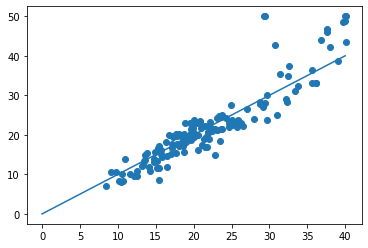

In [51]:
print(test_pred[0], len(test_pred))
print(test_actual[0], len(test_actual))

import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(test_pred, test_actual)
plt.plot((0, 40), (0, 40))
